## Импорт / import

Необходимые библитеки и модули:
<br>
pandas - для загрузки датасета, исследование и предварительного анализа
<br>
numpy - для работы с массивами и тензорами
<br>
pickle - для сохранения объектов моделей в файл
<br>
maptplotlib.pyplot, seaborn - для построения графиков, визуализации
<br>
sklearn - основная библитека машинного обучения
<br>
<br>
из нее применяются:
<br>
<br>
StandartScaler - для масштабирования входных параметров
<br>
train_test_split - для разделения выборки на тренировочную и тестовую
<br>
LinearRegression - простая модель линейной регрессии
<br>
RandomForestRegressor - анасамбль случайный лес из решающих деревьев
<br>
mean_squared_error - среднеквадратичная ошибка
<br>
r2_score - коэффициент детерминации
<br>
mean_absolute_error - средняя абсолютная ошибка

<br>
<br>
tensorflow - одна из основных библиотек разработки нейронных сетей, в данной работе используется tensorflow.keras

In [98]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf

## Анализ данных / analysis

Производится загрузка, анализ и дальнейшая обработка датасета по кейсу электронно-лучевой сварки
<br>
Electron beam welding case dataset loading, analysis and processing

In [21]:
# загружаем исходный датасет
# load original dataset
data = pd.read_csv('ebw_data.csv')

In [22]:
# первые 5 элементов
# first 5 elements
data.head(5)

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48


IW; IF; VW; FP - входные параметры / input parameters
<br>
Depth, Width - целевой выход / target output

In [63]:
# описание датасета
# dataset description
data.describe()

,IW,IF,VW,FP,Depth,Width
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,45.666667,141.333333,8.638889,78.333333,1.195556,1.970417
std,1.678363,5.145763,2.061078,21.493530,0.225081,0.279040
min,43.000000,131.000000,4.500000,50.000000,0.800000,1.680000
25%,44.000000,139.000000,8.000000,60.000000,1.080000,1.760000
50%,45.500000,141.000000,9.000000,80.000000,1.200000,1.840000
75%,47.000000,146.000000,10.000000,80.000000,1.290000,2.050000
max,49.000000,150.000000,12.000000,125.000000,1.760000,2.600000


Большого разброса между максимумом и минимум по входным параметрам не обнаружено
<br>
Построим несколько графиков чтобы это продемонстрировать


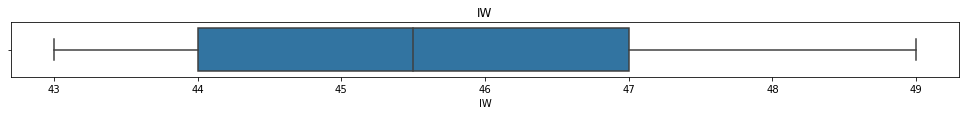

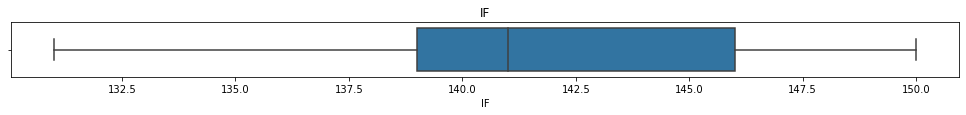

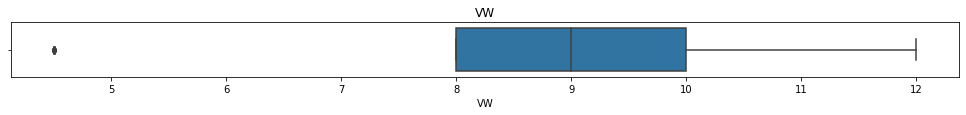

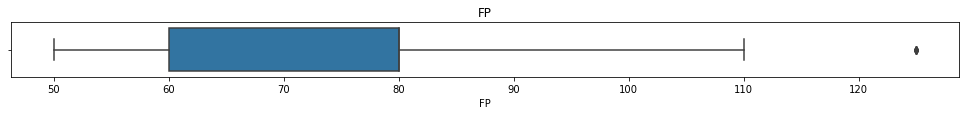

In [64]:
for column in data[['IW','IF','VW','FP']]:
        plt.figure(figsize=(17,1))
        plt.title(column)
        sns.boxplot(data=data, x=column)

In [65]:
# базовая информация о датасете
# dataset basic info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     int64  
 1   IF      72 non-null     int64  
 2   VW      72 non-null     float64
 3   FP      72 non-null     int64  
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 3.5 KB


Из информации о датасете видно, что все строки представляют собой целые числа или числа с плавающей точкой.
<br>
Пропусков в датасете нет, а потому не требуется обработка и замена пропусков.
<br>
Кроме того, нет категориальных признаков, к котором можно было бы применять кодирование (прим, LabelEncdoing или метод pandas.get_dummies())
<br>

In [66]:
# корреляционная матрица
# correlation matrix
data.corr()

,IW,IF,VW,FP,Depth,Width
IW,1.000000,-0.861073,-0.043430,0.835530,-0.289568,0.434869
IF,-0.861073,1.000000,0.115093,-0.980562,0.376084,-0.510167
VW,-0.043430,0.115093,1.000000,-0.001060,-0.671437,-0.874257
FP,0.835530,-0.980562,-0.001060,1.000000,-0.510748,0.412962
Depth,-0.289568,0.376084,-0.671437,-0.510748,1.000000,0.425391
Width,0.434869,-0.510167,-0.874257,0.412962,0.425391,1.000000


Согласно корреляционной матрице прослеживается определенная корреляция между параметрами. Как прямая — стремится к 1, так и обратная — к -1.
<br>
В данном случае больше всего интересуют с чем коррелируются показатели Depth и Width. По таблице выше можно сделать вывод, что все 4 входных параметра требуются и никакие столбцы удалять не стоит.

## Предобработка / preprocessing

In [67]:
# целевые сразу глубина и ширина
# targets are depth and width
y = np.array(data[['Depth', 'Width']])

In [68]:
y[:5]

array([[1.6 , 2.54],
       [1.62, 2.5 ],
       [1.68, 2.6 ],
       [1.58, 2.52],
       [1.76, 2.48]])

In [69]:
# переводим параметры в numpy array
# transform parameters to np array
X = np.array(data[['IW','IF','VW','FP']])

In [70]:
X[:5]

array([[ 47. , 139. ,   4.5,  80. ],
       [ 47. , 139. ,   4.5,  80. ],
       [ 47. , 139. ,   4.5,  80. ],
       [ 47. , 139. ,   4.5,  80. ],
       [ 45. , 140. ,   4.5,  80. ]])

In [71]:
# обучаем на исходном датасете стандартизатор
# fitting scaler with original dataset
scaler = StandardScaler().fit(X)

In [72]:
# сохраним для будущего использования вне ноутбука
# save for future use, outside this notebook
pickle.dump(scaler, open('scaler.pkl', 'wb'))

In [73]:
# масштабируем
# scaling
X_scaled = scaler.transform(X)

In [74]:
X_scaled[:5]

array([[ 0.8       , -0.45662965, -2.02221044,  0.07808688],
       [ 0.8       , -0.45662965, -2.02221044,  0.07808688],
       [ 0.8       , -0.45662965, -2.02221044,  0.07808688],
       [ 0.8       , -0.45662965, -2.02221044,  0.07808688],
       [-0.4       , -0.26093123, -2.02221044,  0.07808688]])

## Обучение и проверка моделей / Model train and test

Далее будут рассмотрены и обучены несколько моделей машинного обучения. Здесь и далее (и в разделе "Нейросеть") буду считать, что достаточным критерием точности и качества работы использованных и настроенных мной моделей будут являться:

mean_squared_error - среднеквадратичная ошибка, не более 0.01
<br>
mean_absolute_error - средняя абсолютная ошибка, не более 0.1
<br>
r2_score - коэффициент детерминации R2, не менее 0.80
<br>

В дальнейшем буду подбирать параметры моделей и осуществлять их выбор исходя из этих критериев. Беру относительно большие значения, т.к. исходный датасет имеет всего 72 элемента и может не позволить обеспечить более точные предсказания в различных ситуациях реальной деятельности. Попытка получить коэффициент превышающие обозначенные мной выше показатели могут свидетельствовать о переобучении модели, т.е. о возможности крайне точных предсказаний на исходном датасете при невозможности или низкой точности предсказаний на других реальных параметрах.

In [75]:
# делим на тестовую и тренировочную выборки, перемешиваем, 20% на тест
# splitting to test and train, shuffling, 20% to the test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=True)

In [76]:
# тренируем простую линеную регрессию
# training simple linear regression
linear_model = LinearRegression().fit(X_train, y_train)

In [77]:
# сохраняем для использования в веб-приложении
# save for web-application use
pickle.dump(linear_model, open('linear_model.pkl', 'wb'))

In [78]:
# предсказания
# predictions
y_pred = linear_model.predict(X_test)

In [79]:
y_pred

array([[1.09220681, 1.77841906],
       [1.09220681, 1.77841906],
       [0.9284009 , 1.93761943],
       [1.10851088, 1.80479943],
       [1.56471377, 2.49651018],
       [1.01741098, 1.58197573],
       [1.10851088, 1.80479943],
       [1.56471377, 2.49651018],
       [1.01741098, 1.58197573],
       [1.45983669, 2.45373984],
       [1.56471377, 2.49651018],
       [0.9284009 , 1.93761943],
       [1.22015372, 1.78263073],
       [1.21536394, 1.73716981],
       [1.23645779, 1.8090111 ]])

In [80]:
y_test

array([[1.  , 1.86],
       [1.04, 1.9 ],
       [0.96, 2.  ],
       [1.2 , 1.86],
       [1.6 , 2.54],
       [1.12, 1.71],
       [1.  , 1.84],
       [1.4 , 2.48],
       [1.2 , 1.8 ],
       [1.64, 2.52],
       [1.62, 2.5 ],
       [0.94, 1.94],
       [1.24, 1.78],
       [1.28, 1.8 ],
       [1.2 , 1.76]])

In [81]:
# среднеквадратичная ошибка
mean_squared_error(y_test, y_pred)

0.008420978290121305

In [82]:
# средняя абсолютная ошибка
mean_absolute_error(y_test, y_pred)

0.0725924744117322

In [83]:
# коэффициент детерминации
r2_score(y_test, y_pred)

0.870482458239103

Пробуем предсказать два разных целевых значения, по одному, на одном и том же наборе входных параметров

In [84]:
# попробуем предсказать отдельно глубину и ширину
# trying to predict width and depth separately

y_depth = y[:,0]

In [85]:
y_depth

array([1.6 , 1.62, 1.68, 1.58, 1.76, 1.72, 1.64, 1.64, 1.2 , 1.2 , 1.16,
       1.2 , 0.98, 1.02, 1.04, 1.  , 1.2 , 1.  , 1.2 , 1.16, 1.12, 1.08,
       1.2 , 1.08, 0.96, 0.96, 0.92, 0.94, 1.36, 1.36, 1.4 , 1.36, 0.84,
       0.86, 0.88, 0.8 , 0.84, 0.84, 0.8 , 0.8 , 1.12, 1.22, 1.12, 1.18,
       1.28, 1.36, 1.36, 1.24, 1.28, 1.32, 1.24, 1.32, 1.08, 1.08, 1.08,
       1.08, 1.2 , 1.2 , 1.2 , 1.2 , 1.2 , 1.24, 1.2 , 1.24, 1.16, 1.2 ,
       1.24, 1.2 , 1.36, 1.28, 1.28, 1.32])

In [86]:
y_width = y[:, 1]

In [87]:
y_width

array([2.54, 2.5 , 2.6 , 2.52, 2.48, 2.48, 2.52, 2.56, 2.  , 1.96, 1.96,
       1.96, 1.84, 1.84, 1.9 , 1.86, 1.78, 1.84, 1.86, 1.8 , 1.71, 1.68,
       1.8 , 1.72, 2.  , 1.94, 1.86, 1.94, 2.52, 2.48, 2.48, 2.48, 2.16,
       2.08, 2.  , 2.04, 2.28, 2.24, 2.24, 2.28, 1.76, 1.82, 1.8 , 1.78,
       1.8 , 1.76, 1.76, 1.76, 1.8 , 1.84, 1.8 , 1.96, 1.8 , 1.82, 1.82,
       1.82, 1.76, 1.86, 1.88, 1.76, 1.76, 1.8 , 1.72, 1.78, 1.76, 1.68,
       1.72, 1.72, 1.76, 1.76, 1.76, 1.76])

In [88]:
X_train_depth, X_test_depth, y_train_depth, y_test_depth = train_test_split(X_scaled, y_depth, test_size=0.2, shuffle=True)

In [89]:
X_train_width, X_test_width, y_train_width, y_test_width = train_test_split(X_scaled, y_width, test_size=0.2, shuffle=True)

In [90]:
depthLinModel = LinearRegression().fit(X_train_depth, y_train_depth)

In [91]:
widthLinMocel = LinearRegression().fit(X_train_width, y_train_width)

In [92]:
depth_pred = depthLinModel.predict(X_test_depth)

In [93]:
width_pred = widthLinMocel.predict(X_test_width)

In [94]:
depth_pred, y_test_depth

(array([0.9383711 , 1.238803  , 1.238803  , 0.9383711 , 0.89528009,
        1.17194798, 1.01592631, 0.89528009, 1.238803  , 1.585635  ,
        1.09341297, 1.238803  , 1.238803  , 1.09341297, 1.21934009]),
 array([0.94, 1.32, 1.2 , 0.96, 0.84, 1.08, 1.12, 0.8 , 1.28, 1.36, 1.02,
        1.24, 1.24, 0.98, 1.36]))

In [95]:
width_pred, y_test_width

(array([1.82079217, 2.50754314, 2.02542248, 1.81963469, 1.94647502,
        2.02983594, 1.76319932, 1.84887521, 1.81963469, 1.60877685,
        1.81963469, 1.81963469, 1.84887521, 1.60877685, 2.45203365]),
 array([1.86, 2.48, 2.08, 1.76, 2.  , 1.96, 1.82, 1.76, 1.76, 1.71, 1.96,
        1.72, 1.76, 1.68, 2.48]))

In [96]:
# серьезного улучшения точности не видно
# no meaningfull improvements in predictions
r2_score(depth_pred, y_test_depth), r2_score(width_pred, y_test_width)

(0.7251492842340792, 0.9087722140633094)

Серьезного увеличения точности предсказания не отмечено

Добавляем еще одну мощную модель машинного обучения из ансамблей - случайный лес из решающих деревьев

In [99]:
forest_model = RandomForestRegressor()

In [100]:
# обучаем
forest_model.fit(X_train, y_train)

RandomForestRegressor()

In [101]:
# сохраняем
pickle.dump(forest_model, open('forest_model.pkl', 'wb'))

In [102]:
y_pred = forest_model.predict(X_test)

In [103]:
y_pred

array([[1.02924857, 1.82973333],
       [1.02924857, 1.82973333],
       [0.93261762, 1.93548762],
       [1.15802667, 1.79188667],
       [1.46663405, 2.5181173 ],
       [1.08765333, 1.71040667],
       [1.15802667, 1.79188667],
       [1.46663405, 2.5181173 ],
       [1.08765333, 1.71040667],
       [1.69561238, 2.4934419 ],
       [1.46663405, 2.5181173 ],
       [0.93261762, 1.93548762],
       [1.21275111, 1.76550365],
       [1.32174857, 1.76      ],
       [1.23221742, 1.80297387]])

In [104]:
y_test

array([[1.  , 1.86],
       [1.04, 1.9 ],
       [0.96, 2.  ],
       [1.2 , 1.86],
       [1.6 , 2.54],
       [1.12, 1.71],
       [1.  , 1.84],
       [1.4 , 2.48],
       [1.2 , 1.8 ],
       [1.64, 2.52],
       [1.62, 2.5 ],
       [0.94, 1.94],
       [1.24, 1.78],
       [1.28, 1.8 ],
       [1.2 , 1.76]])

In [105]:
# коэф детерминации приличный
r2_score(y_pred, y_test)

0.9220530645370493

In [106]:
mean_absolute_error(y_pred, y_test), mean_squared_error(y_pred, y_test)

(0.05025272285557572, 0.0042060283352769925)

Решающий лес показывает высокую точность предсказания даже на параметрах по умолчанию. Однако, возможно переобучение на текущем датасете в виду сложности применяемого инструмента по сравнению с размерами набора данных.

### Модель Ridge и GridSearchCV

Попробуем еще одну линейную модель - Ридж или гребневая регрессия. Для ее оптимальной работы требуется найти лучший или хотя бы достаточной хороший коэффициент альфа (или лямбда). Буду делать это с помощью инструмента GridSearchCV. В него передаётся модель машинного обучения и список параметров для проверки качества.

In [108]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [128]:
# создадим список возможны значений альфа от 0.001 до 10 с шагом 0.001
# possible alpha values list from 0.001 to 10 with step 0.001
parameters = {'alpha': np.arange(0.001, 10, 0.001)}

In [129]:
model = Ridge()
# Ищем наилучший результат при разных значения альфа для метрики отрицательная среднеквадр. ошибка, кросс валидация 5-fold
# finding best alphas for negative MSE metrics with 5-fold cross-validation
ridge_reg = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=5)

In [130]:
# тренируем на всем отмасштабированном датасете
# fitting on all scaled dataset
ridge_reg.fit(X_scaled, y)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([1.000e-03, 2.000e-03, 3.000e-03, ..., 9.997e+00, 9.998e+00,
       9.999e+00])},
             scoring='neg_mean_squared_error')

In [131]:
# лучшая модель
# best model
ridge_reg.best_estimator_

Ridge(alpha=0.001)

In [132]:
ridge_model = ridge_reg.best_estimator_

In [133]:
# обучаем модель на тренировочной выборке
# fitting best model on train split
ridge_model.fit(X_train, y_train)

Ridge(alpha=0.001)

In [134]:
y_pred = ridge_model.predict(X_test)

In [135]:
y_pred

array([[1.09214376, 1.77843964],
       [1.09214376, 1.77843964],
       [0.92834933, 1.93763725],
       [1.10847423, 1.80481202],
       [1.56464578, 2.49651307],
       [1.01734149, 1.58200068],
       [1.10847423, 1.80481202],
       [1.56464578, 2.49651307],
       [1.01734149, 1.58200068],
       [1.45982621, 2.45373158],
       [1.56464578, 2.49651307],
       [0.92834933, 1.93763725],
       [1.22013179, 1.78263926],
       [1.21539161, 1.73716453],
       [1.23646227, 1.80901164]])

In [136]:
y_test

array([[1.  , 1.86],
       [1.04, 1.9 ],
       [0.96, 2.  ],
       [1.2 , 1.86],
       [1.6 , 2.54],
       [1.12, 1.71],
       [1.  , 1.84],
       [1.4 , 2.48],
       [1.2 , 1.8 ],
       [1.64, 2.52],
       [1.62, 2.5 ],
       [0.94, 1.94],
       [1.24, 1.78],
       [1.28, 1.8 ],
       [1.2 , 1.76]])

In [137]:
# показатели качества
# model quality
r2_score(y_pred, y_test), mean_absolute_error(y_pred, y_test), mean_squared_error(y_pred, y_test)

(0.8657176393875199, 0.07259450905460693, 0.00842055987671559)

Произведенные действия показывают, что точность модели сопоставима с линейной регрессией. Вероятно есть относительно простая линейная зависимость между входными параметрами и выходными данными. В готовом приложении буду использовать только линейную регрессию и случайный лес для данного конкретного датасета.

## Нейронная сеть / neural network

Архитектура нейронной сети на keras представляет собой модель Sequential с тремя полносвязными слоями. Активационным функциями relu и сигмоиды. 
<br>
Функция потерь - средняя абсолютная ошибка, метрика - точность, оптимизатор Adam - метод стохастического градиентного спуска со скоростью обучения 0.001

In [188]:
NN_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=100, activation='sigmoid'),
    tf.keras.layers.Dense(units=2)
])

NN_model.compile(loss=tf.keras.losses.mean_absolute_error,
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=['accuracy'])


Архитектура нейронной сети была подобрана экспериментально, функция relu как стандарт для задач регрессии по материалам обучения, сигмоида добавляена для создания элемента нелинейности. Количество нейронов на выходном слое соответствует число прогнозируемых данных (Width и Depth). Число нейронов на двух других слоях подобрано как минимально возможное для высокого качества модели на обучающих данных в условиях конкретной реализации. При уменьшении числа нейронов точность предсказания значительно падает, при увеличении - заметного роста не наблюдается.

In [189]:
# обучение нейросети 
# neural net fitting
history = NN_model.fit(
    X_scaled,
    y,
    epochs=40,
    verbose=0,
    validation_data=(X_test,y_test)
)

Нейронная сеть обучалась на всём имеющемся отмасштабированном массиве данных в связи с малым размером датасета. Число эпох = 40 также было подобрано экспериментально на нескольких прогонах, при уменьшении числа эпох точность теряется, при увеличении незначительно растёт, но есть риск переобучения.

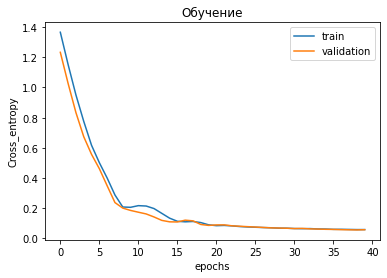

In [190]:
# визуализация
# training visualization
plt.title('Обучение')
plt.xlabel('epochs')
plt.ylabel('Cross_entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

Выше представлена визуализация значений функции потерь в зависимости от числа эпох на тренировочной и тестовой выборках. Можно увидеть что нейросеть обучилось достаточно

In [191]:
y_pred = NN_model.predict(X_test)

1/1 [==============================] - 0s 67ms/step


In [145]:
y_pred

array([[1.0155966 , 1.8655343 ],
       [1.0155966 , 1.8655343 ],
       [0.93991065, 1.9545974 ],
       [1.1049832 , 1.8151422 ],
       [1.5566865 , 2.504301  ],
       [1.121251  , 1.7721658 ],
       [1.1049832 , 1.8151422 ],
       [1.5566865 , 2.504301  ],
       [1.121251  , 1.7721658 ],
       [1.6498266 , 2.5021071 ],
       [1.5566865 , 2.504301  ],
       [0.93991065, 1.9545974 ],
       [1.1794316 , 1.7998692 ],
       [1.2980679 , 1.7702386 ],
       [1.1854885 , 1.8059728 ]], dtype=float32)

In [192]:
y_test

array([[1.  , 1.86],
       [1.04, 1.9 ],
       [0.96, 2.  ],
       [1.2 , 1.86],
       [1.6 , 2.54],
       [1.12, 1.71],
       [1.  , 1.84],
       [1.4 , 2.48],
       [1.2 , 1.8 ],
       [1.64, 2.52],
       [1.62, 2.5 ],
       [0.94, 1.94],
       [1.24, 1.78],
       [1.28, 1.8 ],
       [1.2 , 1.76]])

In [193]:
mean_squared_error(y_test, y_pred)

0.0052372805482257066

In [194]:
# средняя абс ошибка и коэф детерминации
# MAE and R2 coef
mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)

(0.05564045302073162, 0.9263122695767945)

In [195]:
# тестируем возможный пользовательский ввод на примерах из датасета
# testing possible user inputs on dataset examples
scaler.transform(np.array([[46., 141., 10.0, 80.]]))

array([[ 0.2       , -0.06523281,  0.66502222,  0.07808688]])

In [196]:
# сравниваем
# compare
X_scaled[19], y[19]

(array([ 0.2       , -0.06523281,  0.66502222,  0.07808688]),
 array([1.16, 1.8 ]))

In [197]:
NN_model.predict(scaler.transform(np.array([[46., 141., 10.0, 80.]])))

1/1 [==============================] - 0s 32ms/step


array([[1.1094687, 1.767971 ]], dtype=float32)

In [198]:
NN_model.predict(scaler.transform(np.array([[47., 134., 10.0, 110.]])))

1/1 [==============================] - 0s 23ms/step


array([[0.9268563, 1.975883 ]], dtype=float32)

In [199]:
X_scaled[27], y[27]

(array([ 0.8       , -1.43512176,  0.66502222,  1.48365074]),
 array([0.94, 1.94]))

In [200]:
# сохраняем средствами keras для будущего использования
# save for future use
NN_model.save('nn_model')

INFO:tensorflow:Assets written to: nn_model\assets


In [201]:
# тест загрузки сохраненной модели
# test if it loads ok
loaded_model = tf.keras.models.load_model('nn_model')

In [203]:
# тест предсказаний
# prediction test
loaded_model.predict(scaler.transform(np.array([[47., 134., 10.0, 110.]])))

1/1 [==============================] - 0s 24ms/step


array([[0.9268563, 1.975883 ]], dtype=float32)

По итогам представленной выше работы можно сделать вывод о том, что удалось применить несколько моделей машинного обучения на исходном датасете, сохранить их для дальнейшего использования, и получить результаты с установленной точностью.